In [1]:
import predict_utils
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
n_output = 4
n_epochs = 256
batch_size = 64
lr_init = 0.01
n_input = 7
n_hidden = 4
seed = 42

In [3]:
model = predict_utils.load_model(n_input, n_output, n_hidden, seed)

In [4]:
train_transformed = pd.read_pickle('tmp/train_transformeed.pkl')
train_transformed

,time,dv1,dv2,mv1,cv1,cv2
0,2022-11-17 00:00:00,-1.252601,-0.192770,0.562829,-0.579064,1.397860
1,2022-11-17 00:00:30,-0.577421,-0.706154,0.683501,-0.568336,1.269103
2,2022-11-17 00:01:00,-1.336999,-0.499144,0.823359,-0.596228,1.236914
3,2022-11-17 00:01:30,-0.746216,-0.032682,0.883948,-0.525902,1.365671
4,2022-11-17 00:02:00,-0.915011,-0.888323,0.826389,-0.606479,1.140346
...,...,...,...,...,...,...
20005,2022-11-23 22:42:30,-0.408626,0.243331,0.556518,0.854874,-1.241660
20006,2022-11-23 22:43:00,-0.577421,0.367537,0.525214,0.866317,-1.209470
20007,2022-11-23 22:43:30,-0.408626,0.270932,0.567121,0.799567,-1.273849
20008,2022-11-23 22:44:00,-0.493023,0.290253,0.546925,0.875376,-1.209470


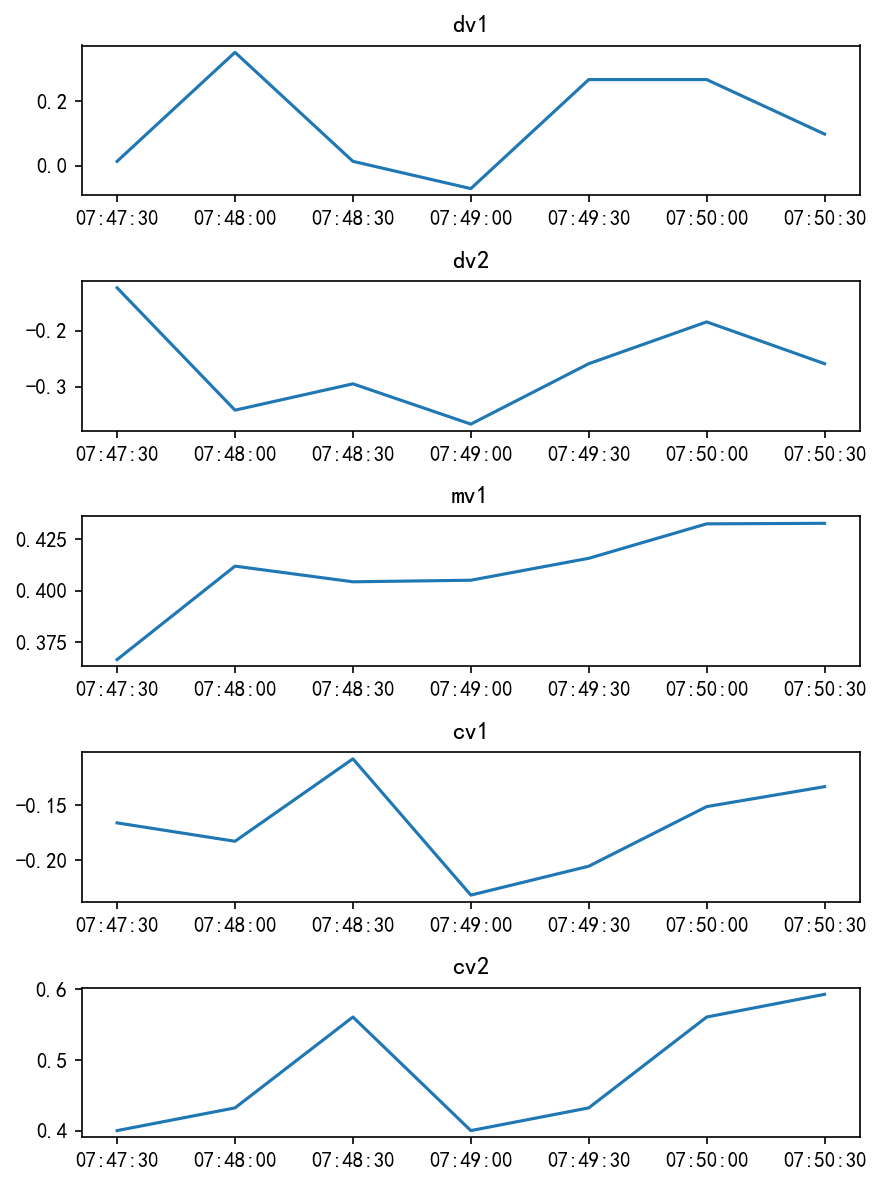

In [9]:
# sample_start = random.randint(0, 20003)
sample_start = 18215
sample_input = train_transformed.iloc[sample_start:sample_start + 7, :]
fig = plt.figure(num=1, figsize=(6, 8), dpi=150)
for i, kpi in enumerate(['dv1', 'dv2', 'mv1', 'cv1', 'cv2']):
    plt.subplot(5, 1, i+1)
    plt.title(kpi)
    plt.plot(sample_input.time, sample_input[kpi])
fig.tight_layout()
plt.savefig('figures/sample_input.svg')
plt.show()

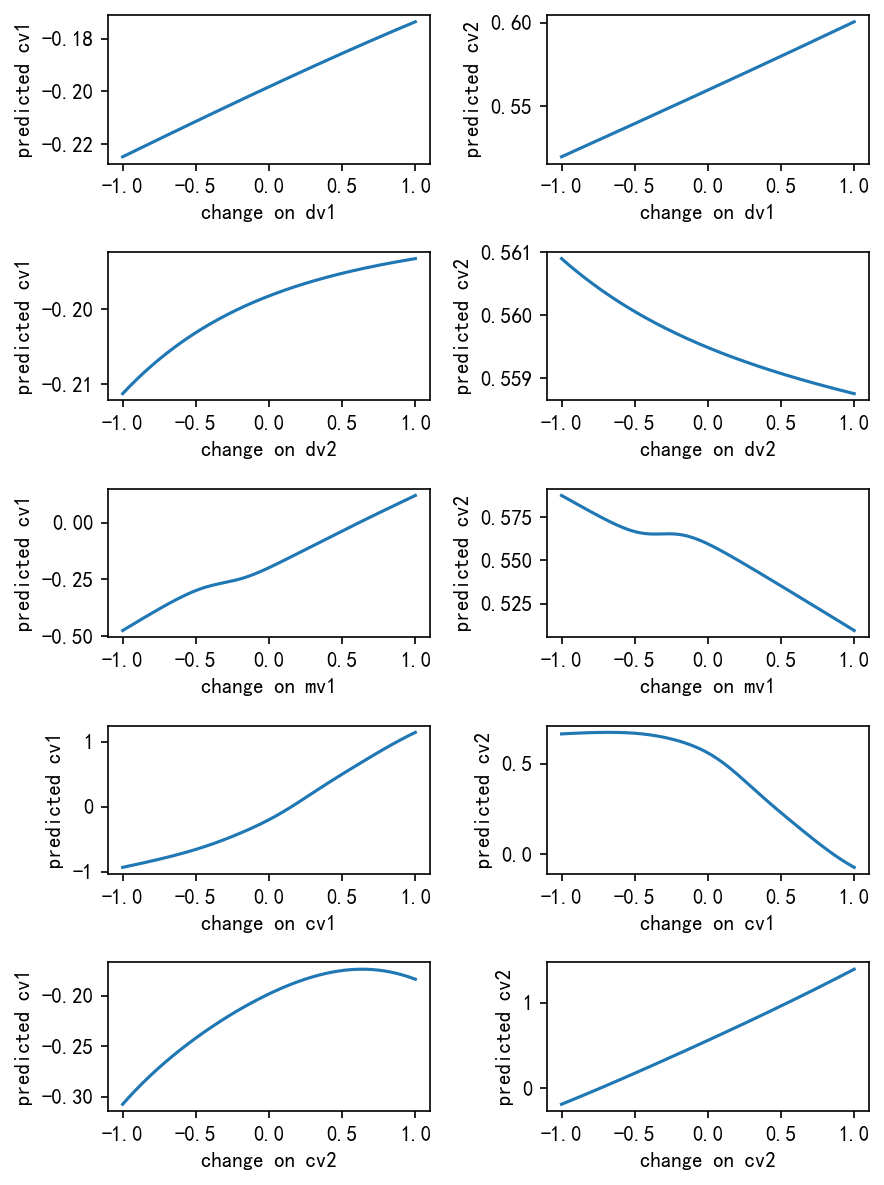

In [10]:
bias = np.arange(-1., 1.0001, 0.01).reshape(-1, 1)
fig = plt.figure(num=1, figsize=(6, 8), dpi=150)
for i, observe_col in enumerate(['dv1', 'dv2', 'mv1', 'cv1', 'cv2']):
    new_input = sample_input.copy()
    target, exog = new_input[['cv1', 'cv2']].values, new_input[['dv1', 'dv2', 'mv1']].values
    target, exog = np.repeat(np.expand_dims(target, axis=0), repeats=bias.shape[0], axis=0), np.repeat(np.expand_dims(exog, axis=0), repeats=bias.shape[0], axis=0)
    if observe_col in ['dv1', 'dv2', 'mv1']:
        exog[:, :, i] += bias
    else:
        target[:, :, i - 3] += bias
    target, exog = torch.tensor(target, device='cpu', dtype=torch.float64), torch.tensor(exog, device='cpu', dtype=torch.float64)
    new_prediction = model.single_predict(target, exog).detach().numpy() # 调用模型的单点预测函数
    for j, kpi in enumerate(['cv1', 'cv2']):
        plt.subplot(5, 2, 2 * i + j + 1)
        plt.xlabel(f'change on {observe_col}')
        plt.ylabel(f'predicted {kpi}')
        plt.plot(bias.flatten(), new_prediction[:, j])
fig.tight_layout()
plt.savefig('figures/observations.svg')
plt.show()
# new_prediction